<a href="https://colab.research.google.com/github/AtilioFPedroni/Pc__Gillespie/blob/main/PC_Gelispe_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q networkx matplotlib numpy pandas seaborn

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

rng = np.random.default_rng()

In [9]:
import tempfile
import os
import gc 

In [4]:
!gfortran fortran/mod_netdata.f90 fortran/mod_random.f90 fortran/mod_read_tools.f90 fortran/dynamics.f90 -o fortran/dynamics

In [12]:
#%%timeit -n 1 -r 1
def simulacao_1D(n, betas, mu=1.0, tf = 100, ni=1, n_amostras=1):
    results = {}

    # geração da rede
    G = nx.circulant_graph(n, [1])
    mapping = {i: i + 1 for i in G.nodes()}
    G = nx.relabel_nodes(G, mapping)

    #temp_dir = '/tmp/teste'
    
    with tempfile.TemporaryDirectory() as temp_dir:
    #if True:
        # Caminho do arquivo temporário
        caminho_do_edgeslist = os.path.join(temp_dir, 'edges.dat')

        nx.write_edgelist(G, caminho_do_edgeslist, data=False)
        os.system('cp fortran/dynamics ' + temp_dir)
        os.system('cp fortran/run.sh ' + temp_dir)

        print(temp_dir)

        for beta in betas:
            results[beta] = []
            for id_da_amostra in range(n_amostras):
                caminho_do_output = os.path.join(temp_dir, f'output_beta_{beta}_{id_da_amostra}.dat')
                os.system(f'cd {temp_dir} && bash run.sh {caminho_do_edgeslist} {caminho_do_output} {id_da_amostra} {beta} {tf} {ni/n} > /dev/null 2>&1')
                
                df = pd.read_csv(caminho_do_output, sep=r'\s+', header=None, names=['t_real','t_pg','f_infectados'])
                df['beta'] = beta
                df['id_da_amostra'] = id_da_amostra

                results[beta].append(df)
            results[beta] = pd.concat(results[beta])
            gc.collect() # evita o uso excessivo de memória            

    results = pd.concat(results.values())
    return results

######################################  Parâmetros ##############################

n = 1000
betas = [2.5,3.2,3.29,3.40,4.00,5.00]
mu = 1.0
tf = 10000
ni = n

results = simulacao_1D(n, betas, mu, tf, ni, n_amostras=10)

results

/tmp/tmp69p0xn2w


,t_real,t_pg,f_infectados,beta,id_da_amostra
0,1.000990,1.000000,0.639,2.5,0
1,1.050004,1.050000,0.628,2.5,0
2,1.103444,1.102500,0.616,2.5,0
3,1.157836,1.157625,0.606,2.5,0
4,1.215681,1.215506,0.600,2.5,0
...,...,...,...,...,...
184,7921.930658,7921.930516,0.723,5.0,9
185,8318.027092,8318.027042,0.717,5.0,9
186,8733.928869,8733.928394,0.724,5.0,9
187,9170.624828,9170.624814,0.769,5.0,9


## Tratando o DataFrame para fazer a média no tempo

In [14]:
results['t_medio'] = results.groupby(['beta', 't_pg'])['t_real'].transform('mean') # faz a mesma coisa, porém replicando o valor para as linhas agrupadas
results.sort_values(by=['beta','t_pg'])

,t_real,t_pg,f_infectados,beta,id_da_amostra,t_medio
0,1.000990,1.000000,0.639,2.5,0,1.000511
0,1.000495,1.000000,0.645,2.5,1,1.000511
0,1.000701,1.000000,0.596,2.5,2,1.000511
0,1.000191,1.000000,0.604,2.5,3,1.000511
0,1.000345,1.000000,0.639,2.5,4,1.000511
...,...,...,...,...,...,...
188,9629.156078,9629.156055,0.728,5.0,5,9629.156229
188,9629.156071,9629.156055,0.722,5.0,6,9629.156229
188,9629.156458,9629.156055,0.743,5.0,7,9629.156229
188,9629.156252,9629.156055,0.713,5.0,8,9629.156229


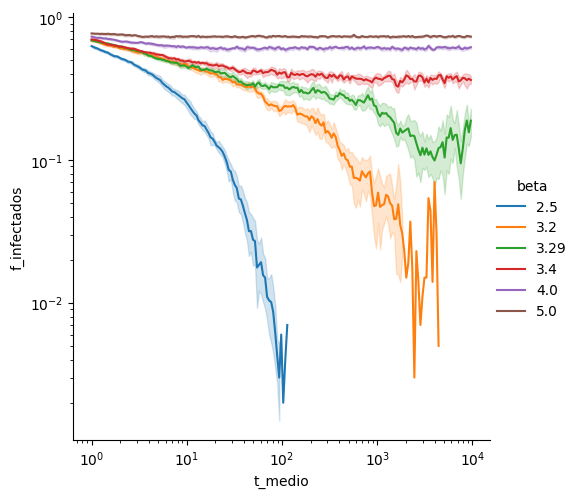

In [15]:
g = sns.relplot(data=results[results['t_medio'] > 0.0], x='t_medio', y='f_infectados', hue='beta', kind='line', markers=True, palette='tab10')
g.set(xscale="log")
g.set(yscale="log")

# Exemplos

In [46]:
# exemplo
results[(np.isclose(results['beta'], 3.29))].groupby('id_da_amostra').size()

id_da_amostra
0    101
1      4
2     79
3     25
4    101
5    101
6      1
7     10
8    101
9     30
dtype: int64

In [40]:
pd.set_option('display.max_rows', 500)
results.groupby(['beta', 't_inteiro'])['t_real'].mean().iloc[0:500]

beta  t_inteiro
0.10  0.0            0.000000
      1.0            1.977713
      2.0            3.431013
      3.0            4.834172
      4.0            4.834172
1.00  0.0            0.000000
      1.0            1.625794
      2.0            2.538729
      3.0            3.327734
      4.0            4.771856
      5.0            5.298380
      6.0            6.029720
      7.0            7.531316
      8.0            8.217246
      9.0            9.031499
1.50  0.0            0.000000
      1.0            1.117308
      2.0            2.241753
      3.0            3.493299
      4.0            4.159590
      5.0            5.170605
      6.0            6.026116
3.29  0.0            0.000000
      1.0            1.092249
      2.0            2.040602
      3.0            3.095660
      4.0            4.096909
      5.0            5.039203
      6.0            6.098816
      7.0            7.042347
      8.0            8.047007
      9.0            9.046317
      10.0          10.0

In [25]:
for _, df in results.groupby(['beta','id_da_amostra']):
    if len(df) > 10:
        break
df

,t_inteiro,t_real,n_infectados,beta,id_da_amostra
0,0.0,0.000000,1,3.29,0
1,1.0,1.005349,3,3.29,0
2,2.0,2.070989,3,3.29,0
3,3.0,3.016718,2,3.29,0
4,4.0,4.300481,4,3.29,0
...,...,...,...,...,...
96,96.0,96.013060,22,3.29,0
97,97.0,97.003481,17,3.29,0
98,98.0,98.022754,16,3.29,0
99,99.0,99.005242,21,3.29,0
